### Imports

In [1]:
from pathlib import Path
import os

import numpy as np
import matplotlib.pyplot as plt
import tifffile
from cellpose.transforms import normalize_img

import sis
from sis.segmentation import CellposeSegmentationMethod

### Load a sample spot table

The test data cannot be uploaded to github since they are too large, so you will have to download them from the brain image library using the `download_merscope_test_files.sh` script   

```
$ bash download_merscope_test_files.sh
```

In [2]:
# The downloadable data is a MERSCOPE experiment result
expt_path = Path(os.path.abspath('')) / "merscope_test_data/"
image_path = expt_path / 'images/'
csv_file = expt_path / 'detected_transcripts.csv'
cache_file = expt_path / 'detected_transcripts.csv.npz'

table = sis.SpotTable.load_merscope(csv_file=csv_file, cache_file=cache_file, image_path=image_path)

Loading from npz..


### Generate training image for a region

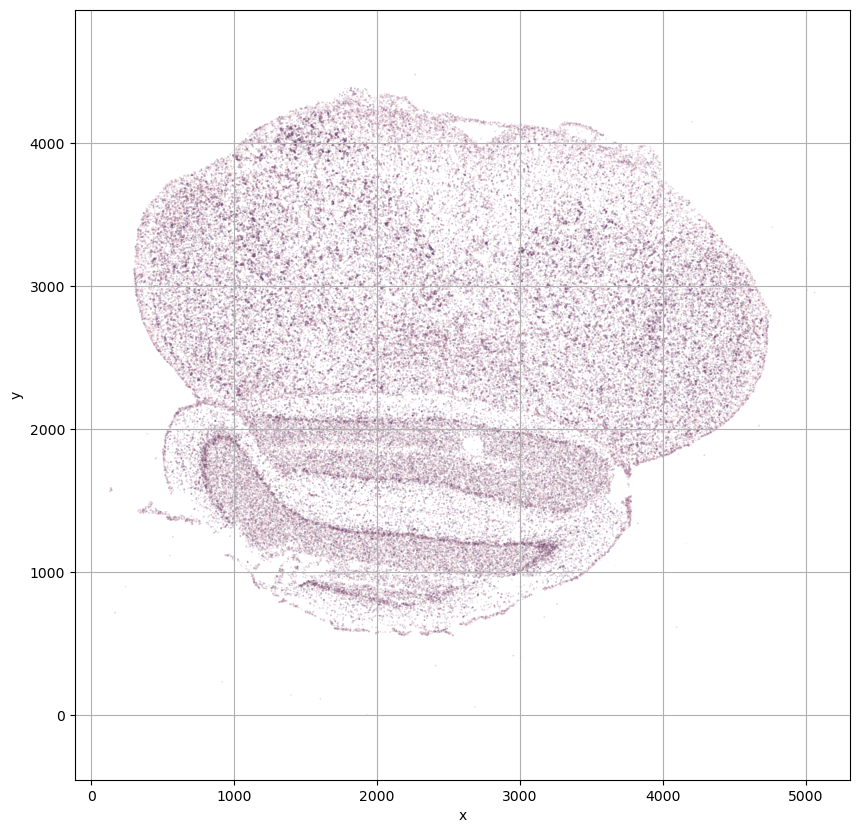

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
table[::200].scatter_plot(ax=ax)
ax.grid();
ax.axis('equal');

In [4]:
def generate_training_image(spot_table, xlim, ylim, z_plane, px_size=0.108, total_z_planes=7, gauss_kernel=(1, 3, 3), median_kernel=(2, 10, 10)):
    subtable = spot_table.get_subregion(xlim=xlim, ylim=ylim)

    seg_method = CellposeSegmentationMethod(options={'px_size': px_size,
                                                     'images': {'nuclei': {'channel': 'DAPI'}, 'cyto': {'channel': 'total_mrna', 'n_planes': total_z_planes, 'gauss_kernel': gauss_kernel, 'median_kernel': median_kernel}}})

    # Generate separate images
    images = {}
    images['nuclei'] = seg_method._read_image_spec(seg_method.options['images']['nuclei'], subtable, px_size=px_size, images=images)
    images['cyto'] = seg_method._read_image_spec(seg_method.options['images']['cyto'], subtable, px_size=px_size, images=images)

    # prepare image data for segmentation
    assert images['cyto'].shape == images['nuclei'].shape
    cyto_data = images['cyto'].get_data()
    image_data = np.empty((images['cyto'].shape[:3]) + (3,), dtype=cyto_data.dtype)
    image_data[..., 0] = cyto_data
    image_data[..., 1] = images['nuclei'].get_data()
    image_data[..., 2] = 0

    return normalize_img(image_data[z_plane])

In [15]:
xlim = (1800, 2000)
ylim = (2800, 3000)
z_plane = 1
training_image = generate_training_image(table, xlim, ylim, z_plane)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


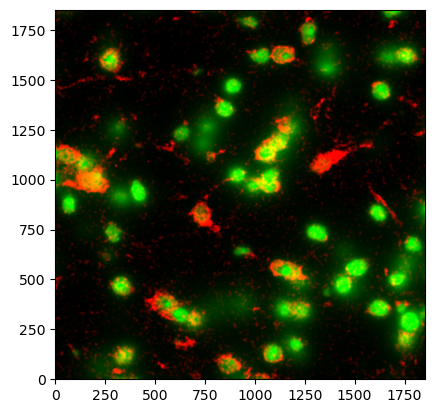

In [17]:
plt.imshow(training_image, origin='lower');

### Save training image to output directory

In [8]:
output_dir = Path(os.path.abspath('')) / "training_images_test/"
os.makedirs(output_dir, exist_ok=True)
tifffile.imwrite(output_dir / 'training_image.tif', training_image)

You want to pick regions which cover a variety of sections, z-planes, and cellular densities. You should use 6 training images at the very least, but you will likely need more to accurately represent the diversity of regions you will be segmenting.

### Same code looped for your convenience in choosing multiple regions

In [ ]:
output_dir = Path(os.path.abspath('')) / "training_images_test/"

# regions is a list of tuples
# each tuple is xlim, ylim, z_plane
regions = [((1800, 2000), (2800, 3000), 1),
           # Add more regions here
           ]
for i, (xlim, ylim, z_plane) in enumerate(regions):
    training_image = generate_training_image(table, xlim, ylim, z_plane)
    tifffile.imwrite(output_dir / f'training_image_{i}.tif', training_image)